In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    labels = dataframe["label"] - 1#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
(12056, 51) (12056, 6)


In [6]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-06-04 00:04:46.451439: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-04 00:04:46.451514: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-06-04 00:04:46.454548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.5412691829116549
1: 0.25964330153463294
2: 0.11406055578598093
3: 0.047698050601410205
4: 0.02789299046038988
5: 0.009435918705931148

TEST DISTRIBUTION
0: 0.5655058043117744
1: 0.2462686567164179
2: 0.11525704809286899
3: 0.0472636815920398
4: 0.02155887230514096
5: 0.0041459369817578775


[0.5412691829116549, 0.25964330153463294, 0.11406055578598093, 0.047698050601410205, 0.02789299046038988, 0.009435918705931148]


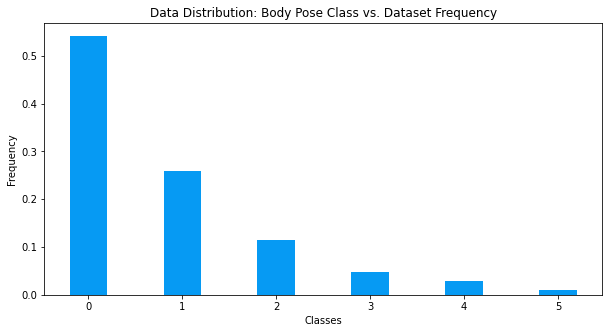

In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)

classes = [0,1,2,3,4,5]
values = sample_dist
print(sample_dist)


fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, values, color ='#069AF3',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Data Distribution: Body Pose Class vs. Dataset Frequency")
plt.show()

In [10]:
sample_dist

[0.5412691829116549,
 0.25964330153463294,
 0.11406055578598093,
 0.047698050601410205,
 0.02789299046038988,
 0.009435918705931148]

In [143]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.88208077 0.4231284  0.18587909 0.07773126 0.04545589 0.01537727]
[1.1336830354812486, 2.3633488199728907, 5.379841313829198, 12.86483792437417, 21.99935109744282, 65.03104884848482]


In [144]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [145]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [146]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 17, 3)        0           ['input_7[0][0]']                
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 17, 2)       0           ['reshape_6[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_54 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_57 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_57[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_13 (TFOpLambda  (None, 17, 2)       0           ['tf.expand_dims_13[0][0]',      
 )                                                                'tf.compat.v1.floor_div_13[0][0]
                                                                 ']                               
                                                                                                  
 tf.__operators__.add_26 (TFOpL  (None, 2)           0           ['tf.math.multiply_58[0][0]',    
 ambda)   

In [147]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [148]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
586/603 [============================>.] - ETA: 0s - loss: 0.1616 - tp: 3000.0000 - fp: 228.0000 - tn: 46652.0000 - fn: 6376.0000 - accuracy: 0.8826 - precision: 0.9294 - recall: 0.3200 - auc: 0.9203 - prc: 0.7665
Epoch 1: val_loss improved from inf to 0.10434, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 6s 7ms/step - loss: 0.1606 - tp: 3116.0000 - fp: 237.0000 - tn: 47983.0000 - fn: 6528.0000 - accuracy: 0.8831 - precision: 0.9293 - recall: 0.3231 - auc: 0.9215 - prc: 0.7692 - val_loss: 0.1043 - val_tp: 619.0000 - val_fp: 31.0000 - val_tn: 5999.0000 - val_fn: 587.0000 - val_accuracy: 0.9146 - val_precision: 0.9523 - val_recall: 0.5133 - val_auc: 0.9673 - val_prc: 0.8937
Epoch 2/200
598/603 [============================>.] - ETA: 0s - loss: 0.1120 - tp: 5049.0000 - fp: 296.0000 - tn: 47544.0000 - fn: 4519.0000 - accuracy: 0.9161 - precision: 0.9446 - recall: 0.5277

603/603 [==============================] - 2s 3ms/step - loss: 0.0770 - tp: 6891.0000 - fp: 335.0000 - tn: 47885.0000 - fn: 2753.0000 - accuracy: 0.9466 - precision: 0.9536 - recall: 0.7145 - auc: 0.9829 - prc: 0.9373 - val_loss: 0.0621 - val_tp: 932.0000 - val_fp: 38.0000 - val_tn: 5992.0000 - val_fn: 274.0000 - val_accuracy: 0.9569 - val_precision: 0.9608 - val_recall: 0.7728 - val_auc: 0.9888 - val_prc: 0.9557
Epoch 12/200
603/603 [==============================] - ETA: 0s - loss: 0.0755 - tp: 6968.0000 - fp: 318.0000 - tn: 47902.0000 - fn: 2676.0000 - accuracy: 0.9483 - precision: 0.9564 - recall: 0.7225 - auc: 0.9833 - prc: 0.9397
Epoch 12: val_loss improved from 0.06173 to 0.05895, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 4s 7ms/step - loss: 0.0755 - tp: 6968.0000 - fp: 318.0000 - tn: 47902.0000 - fn: 2676.0000 - accuracy: 0.9483 - precision: 0.9564 - recall: 0.7225 -

600/603 [============================>.] - ETA: 0s - loss: 0.0642 - tp: 7391.0000 - fp: 285.0000 - tn: 47715.0000 - fn: 2209.0000 - accuracy: 0.9567 - precision: 0.9629 - recall: 0.7699 - auc: 0.9878 - prc: 0.9555
Epoch 33: val_loss improved from 0.04901 to 0.04814, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 5ms/step - loss: 0.0642 - tp: 7423.0000 - fp: 285.0000 - tn: 47935.0000 - fn: 2221.0000 - accuracy: 0.9567 - precision: 0.9630 - recall: 0.7697 - auc: 0.9878 - prc: 0.9555 - val_loss: 0.0481 - val_tp: 972.0000 - val_fp: 35.0000 - val_tn: 5995.0000 - val_fn: 234.0000 - val_accuracy: 0.9628 - val_precision: 0.9652 - val_recall: 0.8060 - val_auc: 0.9933 - val_prc: 0.9732
Epoch 34/200
585/603 [============================>.] - ETA: 0s - loss: 0.0627 - tp: 7279.0000 - fp: 297.0000 - tn: 46503.0000 - fn: 2081.0000 - accuracy: 0.9577 - precision: 0.9608 - recall: 0.7777 - auc

599/603 [============================>.] - ETA: 0s - loss: 0.0603 - tp: 7549.0000 - fp: 306.0000 - tn: 47614.0000 - fn: 2035.0000 - accuracy: 0.9593 - precision: 0.9610 - recall: 0.7877 - auc: 0.9894 - prc: 0.9604
Epoch 44: val_loss improved from 0.04653 to 0.04581, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
603/603 [==============================] - 3s 5ms/step - loss: 0.0605 - tp: 7594.0000 - fp: 311.0000 - tn: 47909.0000 - fn: 2050.0000 - accuracy: 0.9592 - precision: 0.9607 - recall: 0.7874 - auc: 0.9893 - prc: 0.9601 - val_loss: 0.0458 - val_tp: 978.0000 - val_fp: 31.0000 - val_tn: 5999.0000 - val_fn: 228.0000 - val_accuracy: 0.9642 - val_precision: 0.9693 - val_recall: 0.8109 - val_auc: 0.9940 - val_prc: 0.9754
Epoch 45/200
589/603 [============================>.] - ETA: 0s - loss: 0.0621 - tp: 7278.0000 - fp: 280.0000 - tn: 46840.0000 - fn: 2146.0000 - accuracy: 0.9571 - precision: 0.9630 - recall: 0.7723 - auc

585/603 [============================>.] - ETA: 0s - loss: 0.0582 - tp: 7401.0000 - fp: 287.0000 - tn: 46513.0000 - fn: 1959.0000 - accuracy: 0.9600 - precision: 0.9627 - recall: 0.7907 - auc: 0.9903 - prc: 0.9629
Epoch 66: val_loss did not improve from 0.04367
603/603 [==============================] - 2s 3ms/step - loss: 0.0583 - tp: 7625.0000 - fp: 298.0000 - tn: 47922.0000 - fn: 2019.0000 - accuracy: 0.9600 - precision: 0.9624 - recall: 0.7906 - auc: 0.9903 - prc: 0.9627 - val_loss: 0.0459 - val_tp: 989.0000 - val_fp: 34.0000 - val_tn: 5996.0000 - val_fn: 217.0000 - val_accuracy: 0.9653 - val_precision: 0.9668 - val_recall: 0.8201 - val_auc: 0.9940 - val_prc: 0.9753
Epoch 67/200
584/603 [============================>.] - ETA: 0s - loss: 0.0571 - tp: 7394.0000 - fp: 268.0000 - tn: 46452.0000 - fn: 1950.0000 - accuracy: 0.9604 - precision: 0.9650 - recall: 0.7913 - auc: 0.9906 - prc: 0.9642
Epoch 67: val_loss did not improve from 0.04367
603/603 [==============================] - 2s 

Epoch 78/200
600/603 [============================>.] - ETA: 0s - loss: 0.0578 - tp: 7599.0000 - fp: 280.0000 - tn: 47720.0000 - fn: 2001.0000 - accuracy: 0.9604 - precision: 0.9645 - recall: 0.7916 - auc: 0.9905 - prc: 0.9635
Epoch 78: val_loss did not improve from 0.04355
603/603 [==============================] - 2s 3ms/step - loss: 0.0578 - tp: 7627.0000 - fp: 280.0000 - tn: 47940.0000 - fn: 2017.0000 - accuracy: 0.9603 - precision: 0.9646 - recall: 0.7909 - auc: 0.9905 - prc: 0.9634 - val_loss: 0.0442 - val_tp: 984.0000 - val_fp: 29.0000 - val_tn: 6001.0000 - val_fn: 222.0000 - val_accuracy: 0.9653 - val_precision: 0.9714 - val_recall: 0.8159 - val_auc: 0.9946 - val_prc: 0.9773
Epoch 79/200
596/603 [============================>.] - ETA: 0s - loss: 0.0571 - tp: 7584.0000 - fp: 276.0000 - tn: 47404.0000 - fn: 1952.0000 - accuracy: 0.9611 - precision: 0.9649 - recall: 0.7953 - auc: 0.9906 - prc: 0.9641
Epoch 79: val_loss improved from 0.04355 to 0.04304, saving model to weights.best

Epoch 90/200
584/603 [============================>.] - ETA: 0s - loss: 0.0558 - tp: 7480.0000 - fp: 278.0000 - tn: 46442.0000 - fn: 1864.0000 - accuracy: 0.9618 - precision: 0.9642 - recall: 0.8005 - auc: 0.9911 - prc: 0.9657
Epoch 90: val_loss did not improve from 0.04281
603/603 [==============================] - 2s 3ms/step - loss: 0.0558 - tp: 7719.0000 - fp: 288.0000 - tn: 47932.0000 - fn: 1925.0000 - accuracy: 0.9618 - precision: 0.9640 - recall: 0.8004 - auc: 0.9911 - prc: 0.9656 - val_loss: 0.0437 - val_tp: 1002.0000 - val_fp: 34.0000 - val_tn: 5996.0000 - val_fn: 204.0000 - val_accuracy: 0.9671 - val_precision: 0.9672 - val_recall: 0.8308 - val_auc: 0.9946 - val_prc: 0.9772
Epoch 91/200
593/603 [============================>.] - ETA: 0s - loss: 0.0559 - tp: 7588.0000 - fp: 299.0000 - tn: 47141.0000 - fn: 1900.0000 - accuracy: 0.9614 - precision: 0.9621 - recall: 0.7997 - auc: 0.9910 - prc: 0.9659
Epoch 91: val_loss did not improve from 0.04281
603/603 [=======================

Epoch 102/200
601/603 [============================>.] - ETA: 0s - loss: 0.0556 - tp: 7719.0000 - fp: 297.0000 - tn: 47783.0000 - fn: 1897.0000 - accuracy: 0.9620 - precision: 0.9629 - recall: 0.8027 - auc: 0.9913 - prc: 0.9657
Epoch 102: val_loss did not improve from 0.04194
603/603 [==============================] - 2s 3ms/step - loss: 0.0557 - tp: 7741.0000 - fp: 298.0000 - tn: 47922.0000 - fn: 1903.0000 - accuracy: 0.9620 - precision: 0.9629 - recall: 0.8027 - auc: 0.9913 - prc: 0.9656 - val_loss: 0.0426 - val_tp: 1011.0000 - val_fp: 32.0000 - val_tn: 5998.0000 - val_fn: 195.0000 - val_accuracy: 0.9686 - val_precision: 0.9693 - val_recall: 0.8383 - val_auc: 0.9951 - val_prc: 0.9790
Epoch 103/200
594/603 [============================>.] - ETA: 0s - loss: 0.0544 - tp: 7629.0000 - fp: 271.0000 - tn: 47249.0000 - fn: 1875.0000 - accuracy: 0.9624 - precision: 0.9657 - recall: 0.8027 - auc: 0.9915 - prc: 0.9671
Epoch 103: val_loss did not improve from 0.04194
603/603 [===================

Epoch 114/200
591/603 [============================>.] - ETA: 0s - loss: 0.0561 - tp: 7570.0000 - fp: 283.0000 - tn: 46997.0000 - fn: 1886.0000 - accuracy: 0.9618 - precision: 0.9640 - recall: 0.8005 - auc: 0.9912 - prc: 0.9658
Epoch 114: val_loss did not improve from 0.04175
603/603 [==============================] - 2s 3ms/step - loss: 0.0562 - tp: 7713.0000 - fp: 289.0000 - tn: 47931.0000 - fn: 1931.0000 - accuracy: 0.9616 - precision: 0.9639 - recall: 0.7998 - auc: 0.9912 - prc: 0.9657 - val_loss: 0.0429 - val_tp: 1003.0000 - val_fp: 26.0000 - val_tn: 6004.0000 - val_fn: 203.0000 - val_accuracy: 0.9684 - val_precision: 0.9747 - val_recall: 0.8317 - val_auc: 0.9949 - val_prc: 0.9786
Epoch 115/200
583/603 [============================>.] - ETA: 0s - loss: 0.0534 - tp: 7555.0000 - fp: 268.0000 - tn: 46372.0000 - fn: 1773.0000 - accuracy: 0.9635 - precision: 0.9657 - recall: 0.8099 - auc: 0.9918 - prc: 0.9686
Epoch 115: val_loss improved from 0.04175 to 0.04169, saving model to weights

Epoch 137/200
589/603 [============================>.] - ETA: 0s - loss: 0.0522 - tp: 7673.0000 - fp: 284.0000 - tn: 46836.0000 - fn: 1751.0000 - accuracy: 0.9640 - precision: 0.9643 - recall: 0.8142 - auc: 0.9922 - prc: 0.9699
Epoch 137: val_loss did not improve from 0.04077
603/603 [==============================] - 2s 3ms/step - loss: 0.0520 - tp: 7857.0000 - fp: 290.0000 - tn: 47930.0000 - fn: 1787.0000 - accuracy: 0.9641 - precision: 0.9644 - recall: 0.8147 - auc: 0.9922 - prc: 0.9701 - val_loss: 0.0415 - val_tp: 1031.0000 - val_fp: 36.0000 - val_tn: 5994.0000 - val_fn: 175.0000 - val_accuracy: 0.9708 - val_precision: 0.9663 - val_recall: 0.8549 - val_auc: 0.9952 - val_prc: 0.9797
Epoch 138/200
589/603 [============================>.] - ETA: 0s - loss: 0.0525 - tp: 7693.0000 - fp: 264.0000 - tn: 46856.0000 - fn: 1731.0000 - accuracy: 0.9647 - precision: 0.9668 - recall: 0.8163 - auc: 0.9920 - prc: 0.9698
Epoch 138: val_loss did not improve from 0.04077
603/603 [===================

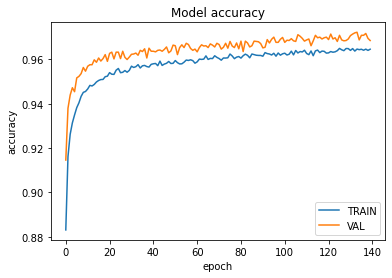

In [149]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

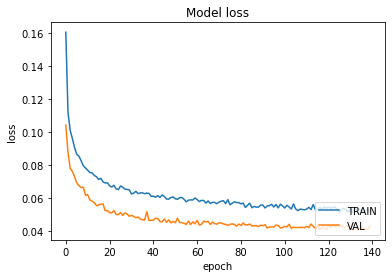

In [150]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [151]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.1272 - tp: 596.0000 - fp: 58.0000 - tn: 5972.0000 - fn: 610.0000 - accuracy: 0.9077 - precision: 0.9113 - recall: 0.4942 - auc: 0.9481 - prc: 0.8263


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79       682
           1       0.55      0.92      0.68       297
           2       0.69      0.76      0.72       139
           3       0.34      0.39      0.36        57
           4       0.72      0.69      0.71        26
           5       0.36      1.00      0.53         5

    accuracy                           0.72      1206
   macro avg       0.61      0.73      0.63      1206
weighted avg       0.81      0.72      0.73      1206



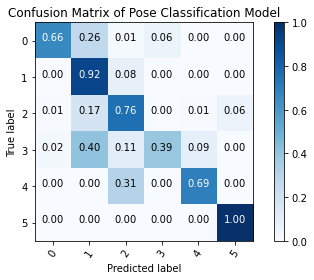

In [152]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
#Classes 3, 4 Need to be weighted

